# GNN on spatial AR process

The main purpose of this notebook is to explore the ability of a Graph Recurrent Neural Network to predict on a spatial auto-regressive process. We begin by implementing a simple model where data are generated on a ring-like graph with an AR(1) spatial lag and an AR(1) temporal lag process. We will implement fitting by splitting the time-series into chunks of a specified sequence length and pass through a GRNN with three layers: a graph convolutional layer, a LSTM layer, and another graph convolutional layer. In the final layer the last point in the time-series is extracted for the h-step ahead prediction.


torch==1.9.0
torch_geometric==1.7.2
networkx==2.6.2
matplotlib==3.4.3
numpy==1.21.2
pandas==1.3.3
pyyaml==5.4.1

In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np




## GNN on spatial AR process


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


In [78]:
class TemporalGNN(torch.nn.Module):
    def __init__(self, num_nodes, num_timesteps, input_dim, hidden_dim, output_dim):
        super(TemporalGNN, self).__init__()
        self.gcn1 = GCNConv(input_dim, hidden_dim)
        self.lstm = torch.nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.gcn2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        batch_size, num_timesteps, input_dim = x.size()
        
        # Apply GCN to each time step
        x = x.reshape(batch_size * num_timesteps, input_dim)
        x = F.relu(self.gcn1(x, edge_index))
        x = x.reshape(batch_size, num_timesteps, -1)
        
        # Apply LSTM for temporal modeling
        x, _ = self.lstm(x)
        
        # Apply GCN to the output of LSTM
        x = x.contiguous().reshape(batch_size * num_timesteps, -1)
        x = self.gcn2(x, edge_index)
        x = x.reshape(batch_size, num_timesteps, -1)
        x = x[:,-1,:]
        # get final time-point in time-series
        
        return x
    
    def hidden_layer(self, data):
        x, edge_index = data.x, data.edge_index
        batch_size, num_timesteps, input_dim = x.size()
        
        # Apply GCN to each time step
        x = x.reshape(batch_size * num_timesteps, input_dim)
        x = F.relu(self.gcn1(x, edge_index))
        x = x.reshape(batch_size, num_timesteps, -1)

        return x

In [72]:
# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

num_nodes = 10
num_timesteps = 100
noise_scale = 0.05
rhos = [0.5,0.1,0.1]
# Simulate more structured traffic data: 10 nodes (e.g., sensors) with 100 time steps

def generate_spatial_ar_process(
    num_nodes = 10,
    num_timesteps = 100,
    rhos = [0.5,0.1,0.2],
    noise_scale = 0.1):
    """generate spatial AR process on a ring network

    Parameters
    ----------
    num_nodes : int, optional
        number of network nodes, by default 10
    num_timesteps : int, optional
        number of time steps for time-series, by default 100
    rhos : list, optional
        auto-regressive terms for self, past node and next node, by default [0.5,0.1,0.2]
    noise_scale : float, optional
        noise process standard deviation, by default 0.1

    Returns
    -------
    array
        time-series of shape (num_nodes,num_timesteps)
    """    
    # Generate time series data with a pattern
    time_series_data = np.zeros((num_timesteps,num_nodes))
    inits = np.random.normal(loc=0.0,scale=noise_scale, size=num_nodes)
    time_series_data[0,:] = inits
    for t in range(1,num_timesteps):
        # assuming a ring graph where each node is dependent on previous and next node modulo number of nodes
        time_series_data[t,:] = rhos[0]*time_series_data[t-1,:] +\
            rhos[1]*np.roll(time_series_data[t-1,:],shift=1) +\
            rhos[2]*np.roll(time_series_data[t-1,:],shift=-1) +\
            np.random.normal(loc=0., scale = noise_scale, size=num_nodes)

    return time_series_data

def create_torch_ts_data(time_series_data):
    """convert numpy to geometric torch timeseries data

    For data generated on a ring with num_nodes nodes and num_timesteps timesteps 
    create a geomtric torch object with the features as the number of past values and
    the outcome (y) as the same time-series values.

    Parameters
    ----------
    time_series_data : numpy.array
        num_timesteps by num_nodes array
    Returns
    -------
    torch_geometric.data.Data object
    """
    num_timesteps,num_nodes = time_series_data.shape 
    # Create edge index for a simple graph (e.g., ring graph)
    edge_index = torch.tensor([[i, (i + 1) % num_nodes] for i in range(num_nodes)] +
                            [[(i + 1) % num_nodes, i] for i in range(num_nodes)], dtype=torch.long).t().contiguous()

    # Convert time series data to PyTorch tensor
    x = torch.tensor(time_series_data, dtype=torch.float).t().contiguous().view(num_nodes, num_timesteps, 1)

    # Create data object
    data = Data(x=x, edge_index=edge_index)

    # y is just a copy of x for now 
    # will do one step ahead prediction in the training step 
    data.y = time_series_data#np.roll(time_series_data,shift=1,axis=0)
    data.y[0,:] = np.zeros(num_nodes)
    data.y = np.swapaxes(data.y,0,1)
    data.y = data.y[:,:,np.newaxis]
    data.y = torch.tensor(data.y,dtype=torch.float)

    return data

time_series_data = generate_spatial_ar_process(rhos = rhos,
                                               num_nodes=num_nodes,
                                               num_timesteps=num_timesteps,
                                               noise_scale=noise_scale)

data = create_torch_ts_data(time_series_data)

In [30]:
print(data.y.shape)
print(data.x.shape)

torch.Size([10, 100, 1])
torch.Size([10, 100, 1])


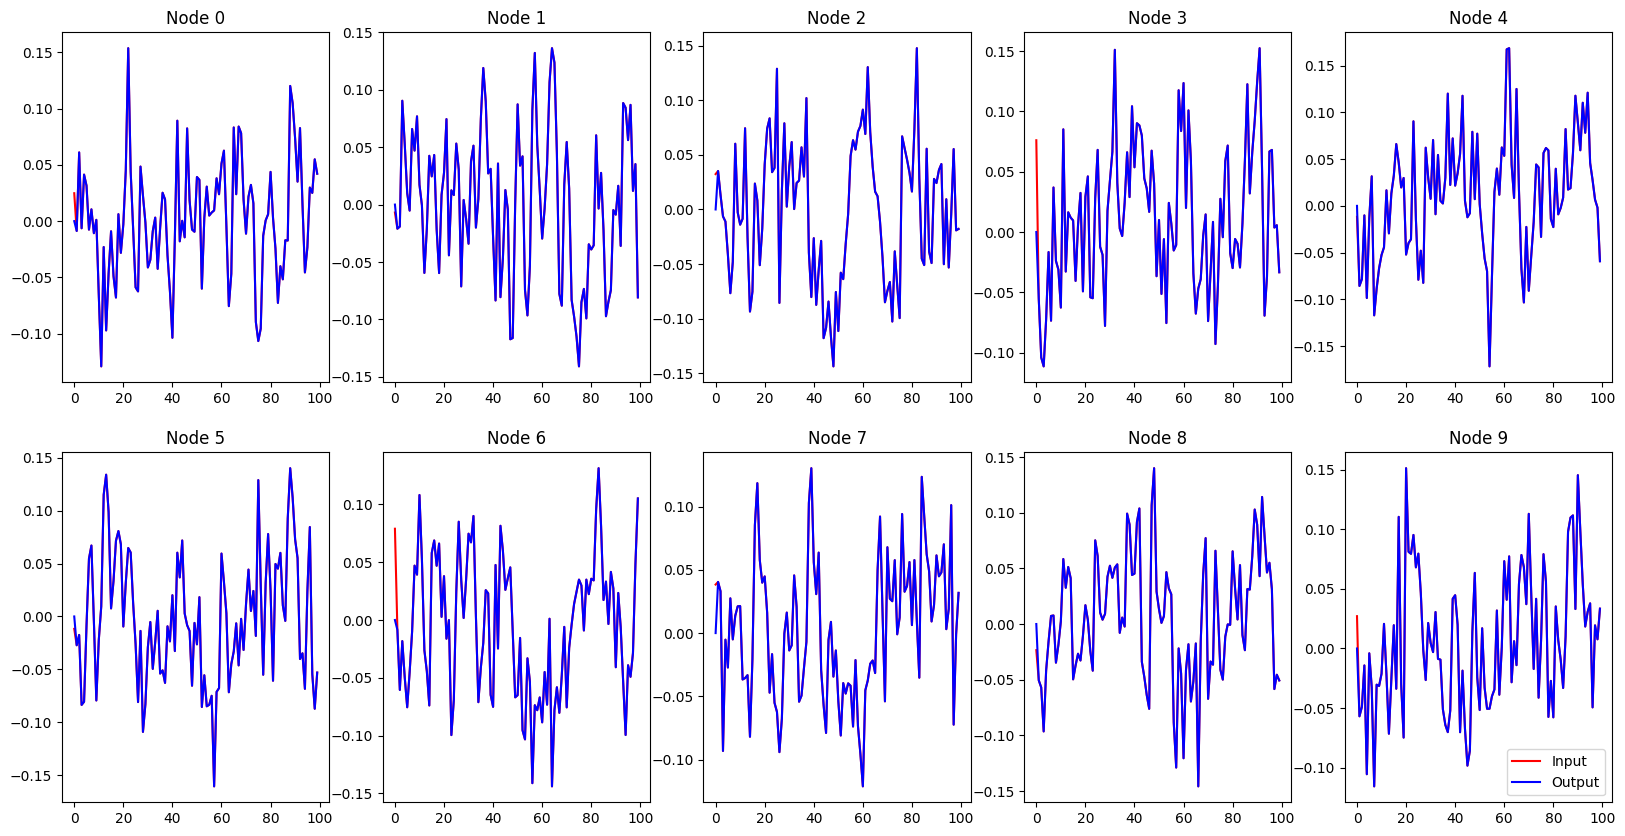

In [31]:
# Plot the actual and predicted time series for each node
plt.figure(figsize=(20, 10))
for i in range(num_nodes):
    plt.subplot(2, 5, i + 1)
    plt.plot(data.x[i,:,0],color="red",label="Input")
    plt.plot(data.y[i,:,0],color="blue",label="Output")
    plt.title(f'Node {i}')
plt.legend()
plt.show()

In [79]:
# Initialize the model
num_nodes = 10
num_timesteps = 100
input_dim = 1
hidden_dim = 32
output_dim = 1
# length of time-series sequence to include
seq_length = 7
# number of steps ahead for prediction
h_step = 1
# number of epochs
num_epochs = 50
model = TemporalGNN(num_nodes, seq_length, input_dim, hidden_dim, output_dim)

# Training setup
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

# save final output in last epoch
model_fit = np.zeros((num_nodes,num_timesteps))
# Training loop
model.train()
for epoch in range(num_epochs):
    for i in range(num_timesteps - seq_length - h_step):
        # chunk data into sequences 
        chunk_data = data.clone()
        chunk_data.x = chunk_data.x[:,i:(i+seq_length),:]

        optimizer.zero_grad()
        out = model(chunk_data)
        loss = criterion(out, data.y[:,i+seq_length+h_step,:])
        loss.backward()
        optimizer.step()
        if epoch == (num_epochs - 1):
            model_fit[:,i+seq_length+h_step] = out[:, 0].detach().numpy()
    if epoch % 5 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')


# Visualization of the graph
def plot_graph(edge_index, num_nodes):
    G = nx.Graph()
    G.add_edges_from(edge_index.t().tolist())
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=500, font_size=15)
    plt.show()

plot_graph(data.edge_index, num_nodes)

# Get the final node embeddings
model.eval()
with torch.no_grad():
    out = model(data)

Epoch 0, Loss: 115.12548828125
Epoch 5, Loss: 90.78763580322266
Epoch 10, Loss: 61.6806640625


KeyboardInterrupt: 

In [39]:
print(model)

TemporalGNN(
  (gcn1): GCNConv(1, 32)
  (lstm): LSTM(32, 32, batch_first=True)
  (gcn2): GCNConv(32, 1)
)


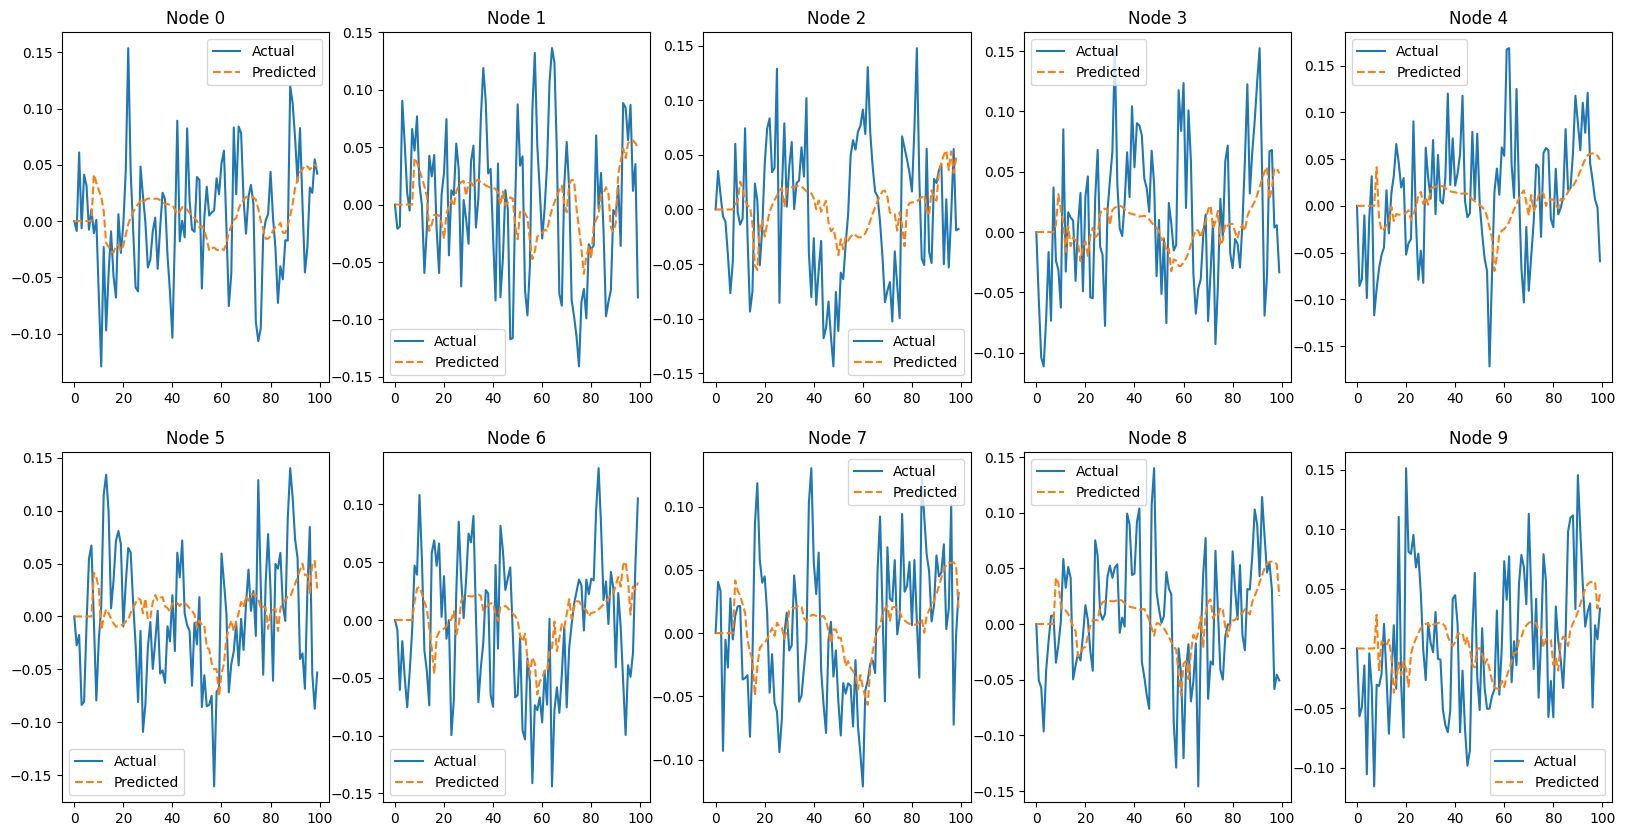

In [41]:

# Plot the actual and predicted time series for each node
plt.figure(figsize=(20, 10))
for i in range(num_nodes):
    plt.subplot(2, 5, i + 1)
    plt.plot(data.y[i, :, 0].numpy(), label='Actual')
    plt.plot(model_fit[i,:], linestyle = "--", label='Predicted')
    plt.title(f'Node {i}')
    plt.legend()
plt.show()

In [43]:
# Set random seed for reproducibility
np.random.seed(4995)
torch.manual_seed(4995)

time_series_data = generate_spatial_ar_process(rhos = rhos,
                                               num_nodes=num_nodes,
                                               num_timesteps=num_timesteps,
                                               noise_scale=noise_scale)

val_data = create_torch_ts_data(time_series_data)

# generate new embeddings
# Get the final node embeddings
model_val = np.zeros((num_nodes,num_timesteps))
model.eval()
with torch.no_grad():
    for i in range(num_timesteps - seq_length - h_step):
        # chunk data into sequences 
        chunk_data = val_data.clone()
        chunk_data.x = chunk_data.x[:,i:(i+seq_length),:]

        out = model(chunk_data)
        model_val[:,i+seq_length+h_step] = out[:, 0].detach().numpy()

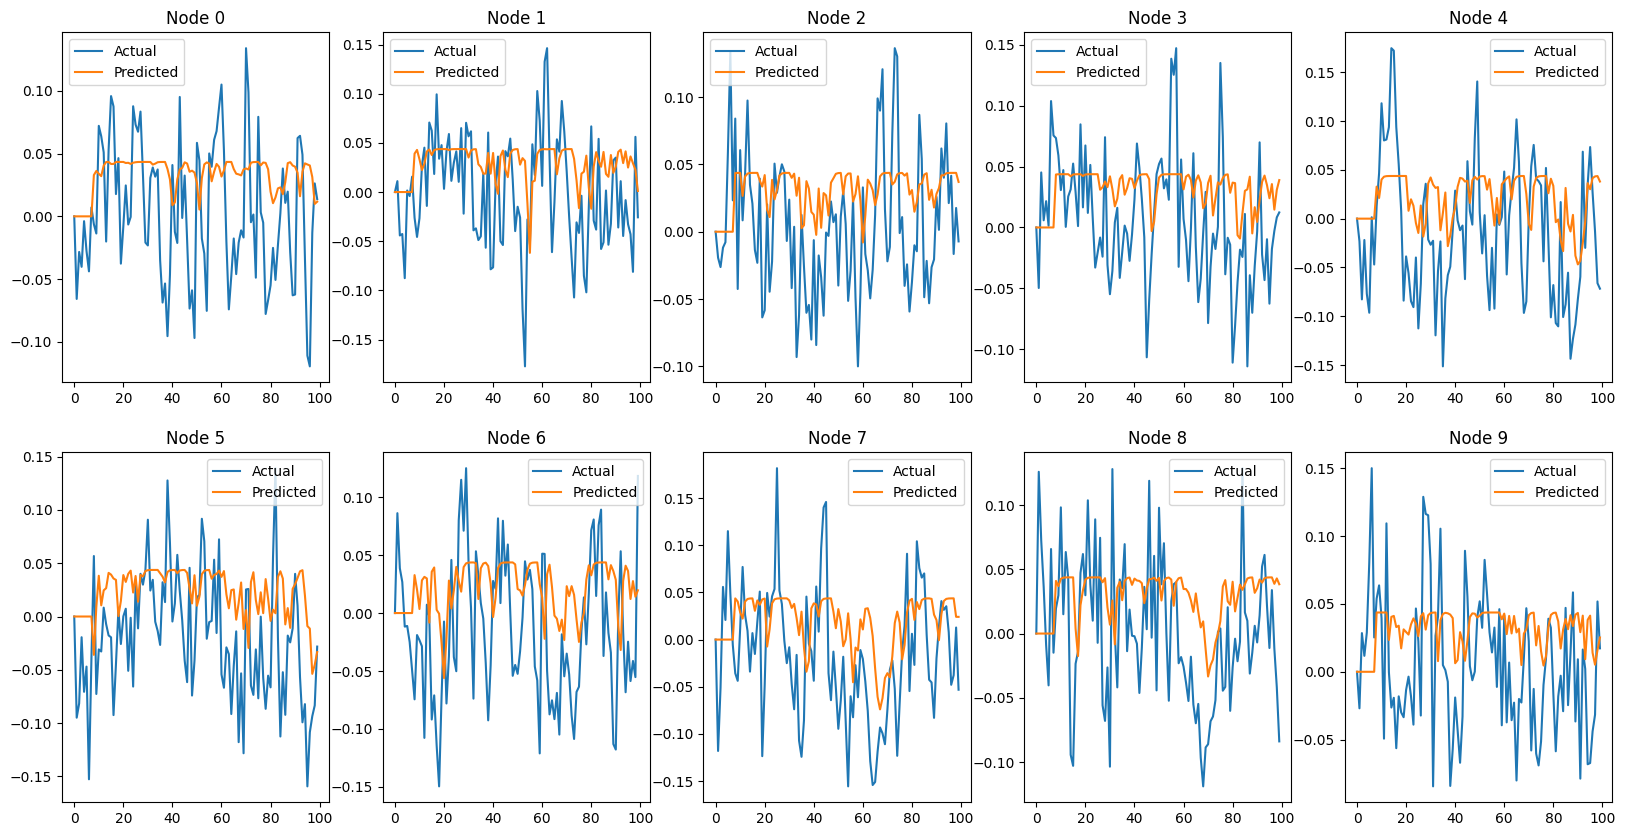

In [44]:
# Plot the actual and predicted time series for each node
plt.figure(figsize=(20, 10))
for i in range(num_nodes):
    plt.subplot(2, 5, i + 1)
    plt.plot(val_data.y[i, :, 0].numpy(), label='Actual')
    plt.plot(model_val[i, :], label='Predicted')
    plt.title(f'Node {i}')
    plt.legend()
plt.show()

## Generate spatial SIR process

The poor performance above may be due to high level of stochasticity and low signal to noise ratio of the AR process. Instead we simulate a stochastic SIRS process that should provide a stronger signal that the GRNN can learn 

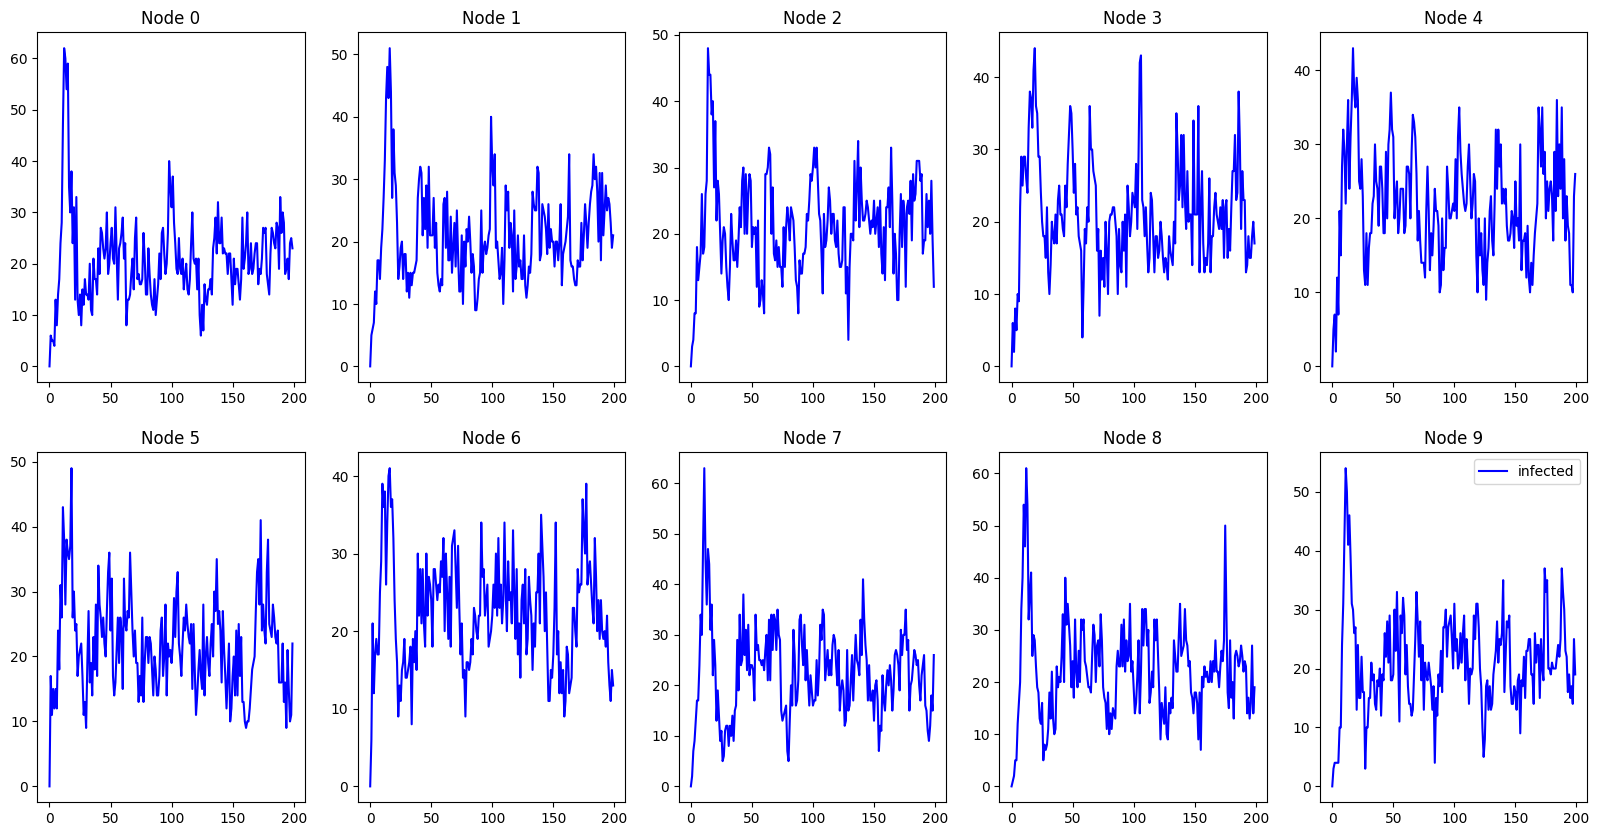

In [73]:
def generate_spatial_sirs_process(
    num_nodes = 10,
    num_timesteps = 100,
    rhos = [0.5,0.1,0.2],
    sigma = 0.01,
    node_population_size = 100,
    noise_scale = 0.1):
    """generate spatial AR process on a ring network

    Parameters
    ----------
    num_nodes : int, optional
        number of network nodes, by default 10
    num_timesteps : int, optional
        number of time steps for time-series, by default 100
    rhos : list, optional
        infectious terms for self, past node and next node, by default [0.5,0.1,0.2]
    n : int
        number of individuals per node
    noise_scale : float, optional
        noise process standard deviation, by default 0.1

    Returns
    -------
    array
        time-series of shape (num_nodes,num_timesteps)
    """    
    # Generate time series data with a pattern
    s_state = np.zeros((num_timesteps,num_nodes))
    i_state = np.zeros((num_timesteps,num_nodes))
    r_state = np.zeros((num_timesteps,num_nodes))

    # set initial conditions
    s_state[0,:] = node_population_size

    inits = np.random.poisson(lam=5, size=num_nodes)
    i_state[0,:] = inits
    time_series_data[0,:] = inits
    for t in range(1,num_timesteps):
        # force of infection
        beta = rhos[0]*i_state[t-1,:] +\
            rhos[1]*np.roll(i_state[t-1,:],shift=1) +\
            rhos[2]*np.roll(i_state[t-1,:],shift=-1) +\
            np.random.normal(loc=0., scale = noise_scale, size=num_nodes)
        beta = np.maximum(beta,0)
        mu_I = beta*s_state[t-1,:]/node_population_size
        immunity_loss = np.random.poisson(r_state[t-1,:]*sigma,size=num_nodes)
        i_state[t,:] = np.random.poisson(mu_I)
        s_state[t,:] = np.maximum(immunity_loss + s_state[t-1,:] - i_state[t,:],0)
        r_state[t,:] = np.maximum(r_state[t-1,:] + i_state[t-1,:] - immunity_loss,0) 


    return {"s": s_state, "i" : i_state, "r" : r_state}

np.random.seed(1123)
p = {'rhos':0.35*np.array([1.,1.5,1.2]), 
     'sigma':0.1, 
     'noise_scale' : 0.0, 
     'node_population_size' : 1000, 
     'num_timesteps': 200}

# create both test data and validation data independently 
states = generate_spatial_sirs_process(**p)
val_states = generate_spatial_sirs_process(**p)

data = create_torch_ts_data(states["i"])
val_data = create_torch_ts_data(states["i"])

# Plot the actual and predicted time series for each node
plt.figure(figsize=(20, 10))
for i in range(num_nodes):
    plt.subplot(2, 5, i + 1)
    plt.plot(states["i"][:,i],color="blue",label="infected")
    #plt.plot(states["s"][:,i],color="red",label="susceptible")
    plt.title(f'Node {i}')
plt.legend()
plt.show()

### Fit GRNN model to SIRS time-series data

Epoch 0, train Loss: 26.77, validation loss: 26.67
Epoch 5, train Loss: 28.58, validation loss: 28.47
Epoch 10, train Loss: 36.12, validation loss: 35.64
Epoch 15, train Loss: 38.40, validation loss: 38.03
Epoch 20, train Loss: 38.82, validation loss: 38.24
Epoch 25, train Loss: 39.25, validation loss: 38.64
Epoch 30, train Loss: 39.28, validation loss: 38.76
Epoch 35, train Loss: 39.50, validation loss: 39.15
Epoch 40, train Loss: 38.89, validation loss: 38.61
Epoch 45, train Loss: 38.55, validation loss: 38.44


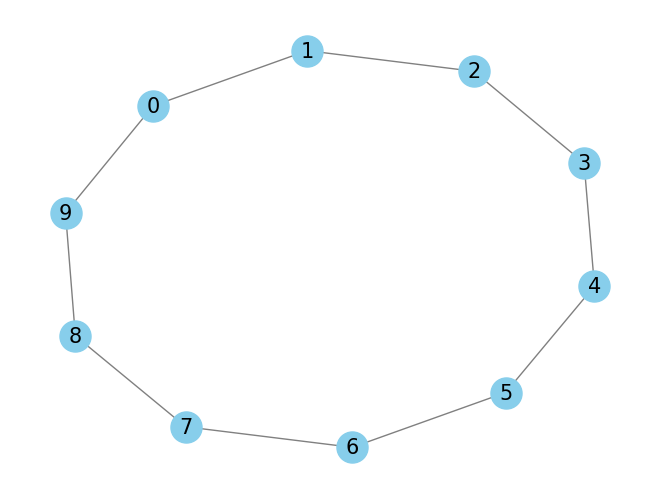

In [80]:
# Initialize the model
num_nodes = states["i"].shape[1]
num_timesteps = states["i"].shape[0]
input_dim = 1
hidden_dim = 32
output_dim = 1
# length of time-series sequence to include
seq_length = 7
# number of steps ahead for prediction
h_step = 1
# number of epochs
num_epochs = 50
model = TemporalGNN(num_nodes, seq_length, input_dim, hidden_dim, output_dim)

# Training setup
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

# save final output in last epoch
model_fit = np.zeros((num_nodes,num_timesteps,num_epochs//10))
# Training loop
model.train()
for epoch in range(num_epochs):
    for i in range(num_timesteps - seq_length - h_step):
        # chunk data into sequences 
        chunk_data = data.clone()
        chunk_data.x = chunk_data.x[:,i:(i+seq_length),:]

        optimizer.zero_grad()
        out = model(chunk_data)
        loss = criterion(out, data.y[:,i+seq_length+h_step,:])
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            model_fit[:,i+seq_length+h_step,(epoch+1)//10] = out[:, 0].detach().numpy()
    if epoch % 5 == 0:
        chunk_data = val_data.clone()
        chunk_data.x = chunk_data.x[:,i:(i+seq_length),:]

        out = model(chunk_data)
        val_loss = criterion(out, val_data.y[:,i+seq_length+h_step,:])
        mse = loss.item()
        print(f'Epoch {epoch}, train Loss: {loss.item():.2f}, validation loss: {val_loss.item():.2f}')


# Visualization of the graph
def plot_graph(edge_index, num_nodes):
    G = nx.Graph()
    G.add_edges_from(edge_index.t().tolist())
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=500, font_size=15)
    plt.show()

plot_graph(data.edge_index, num_nodes)

# Get the final node embeddings
model.eval()
with torch.no_grad():
    out = model(data)

### Show results of fit at different epochs

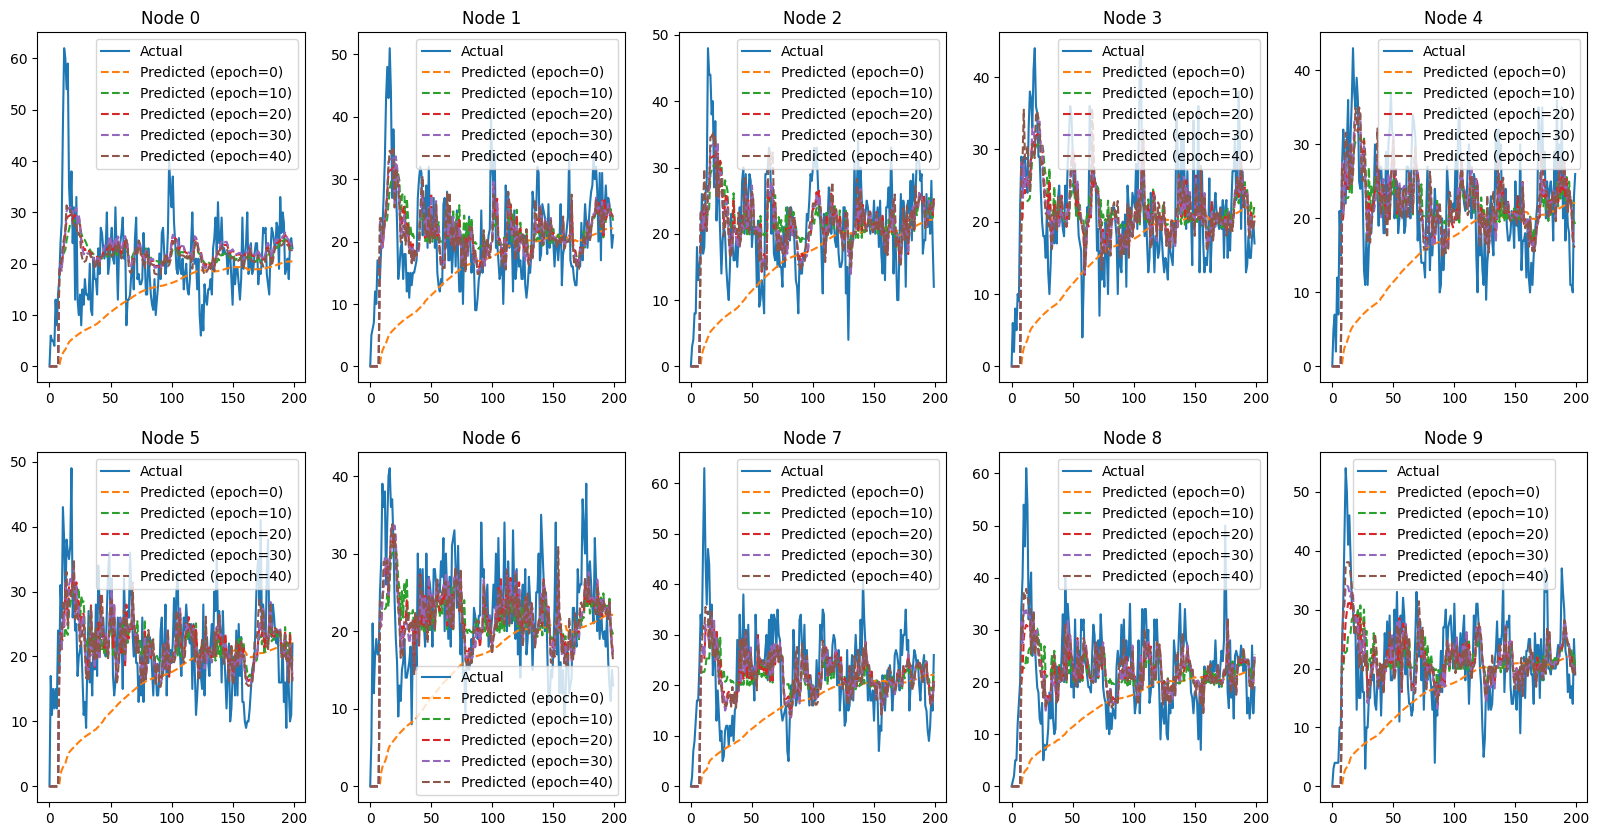

In [81]:
# Plot the actual and predicted time series for each node
plt.figure(figsize=(20, 10))
for i in range(num_nodes):
    plt.subplot(2, 5, i + 1)
    plt.plot(data.y[i, :, 0].numpy(), label='Actual')
    for k in range(model_fit.shape[2]):
        plt.plot(model_fit[i,:,k], linestyle = "--", label=f'Predicted (epoch={k*10})')
    plt.title(f'Node {i}')
    plt.legend()
plt.show()

### Show first hidden GCN layer

In [87]:
model.eval()
with torch.no_grad():

        # chunk data into sequences 
        chunk_data = data.clone()
        chunk_data.x = data.x[:,:,:]

        out = model(chunk_data)
        res = model.hidden_layer(chunk_data)
        #model_val[:,i+seq_length+h_step] = out[:, 0].detach().numpy()
        #loss = criterion(out, val_data.y[:,i+seq_length+h_step,:])
        #mse = loss.item()

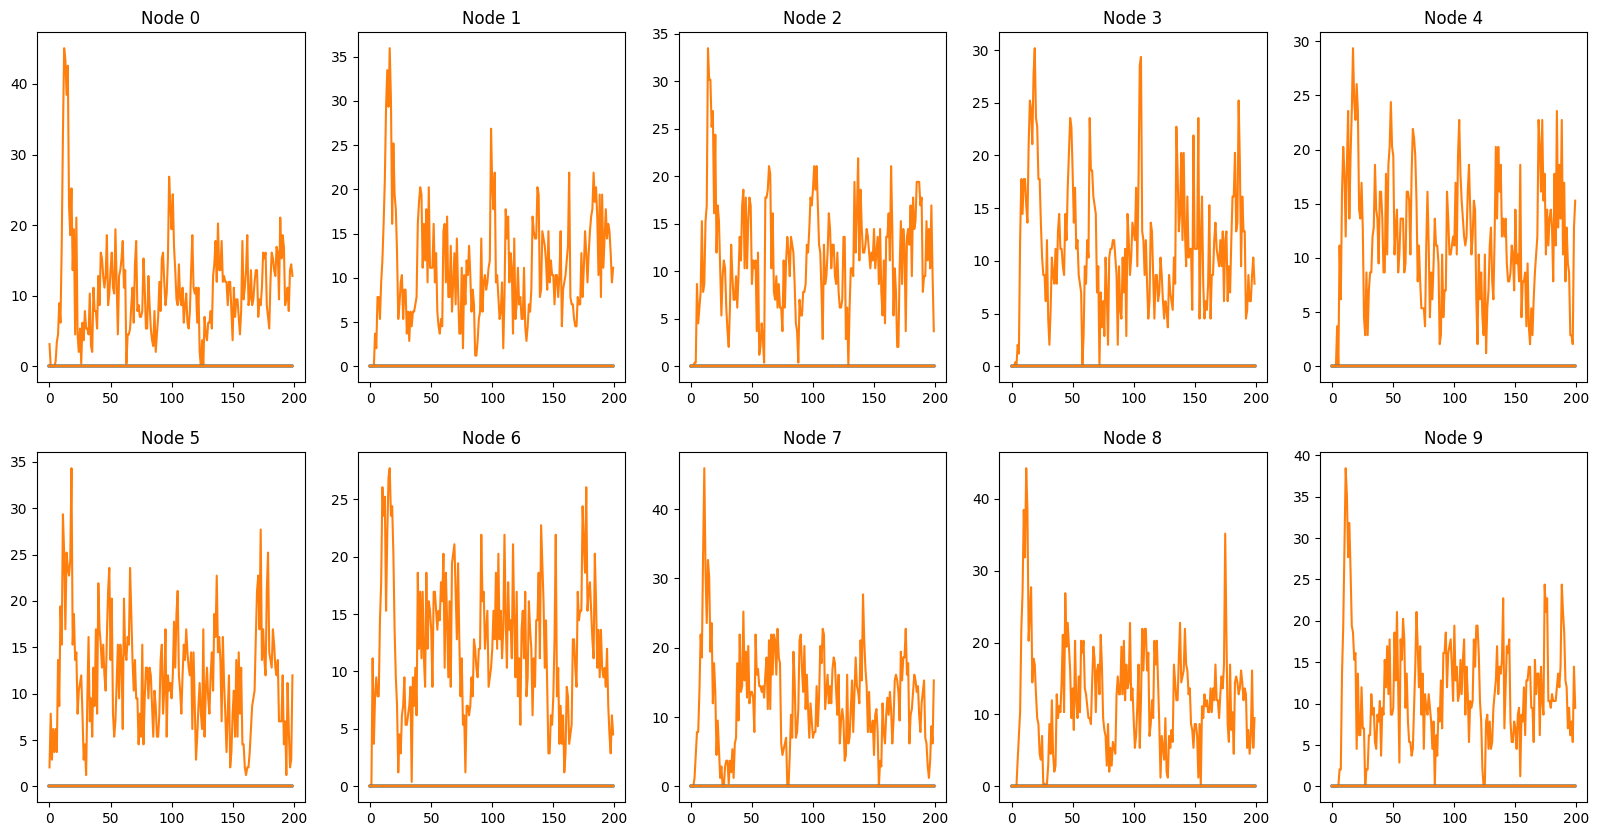

In [88]:
# Plot the actual and predicted time series for each node
plt.figure(figsize=(20, 10))
for i in range(num_nodes):
    plt.subplot(2, 5, i + 1)
    for k in range(res.shape[2]):
        plt.plot(res[i, :, k].numpy(), label=f'hidden layer {k}')
    plt.title(f'Node {i}')
plt.show()

### Apply model to validation data

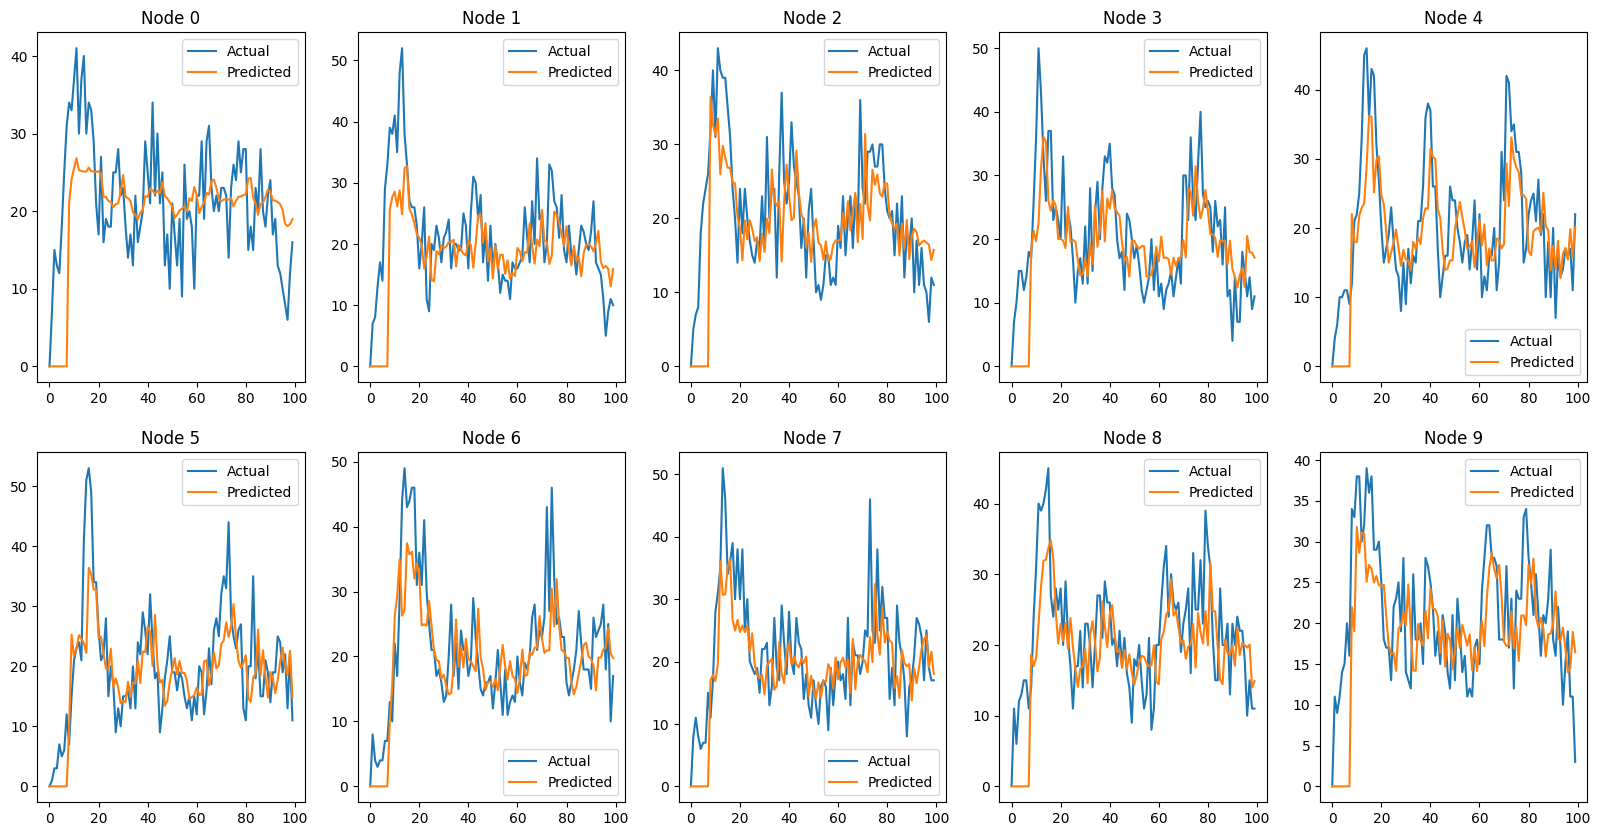

Test MSE: 32.68029022216797


In [67]:
# Set random seed for reproducibility
np.random.seed(4995)
torch.manual_seed(4995)

val_states = generate_spatial_sirs_process(**p)

val_data = create_torch_ts_data(val_states["i"])

# generate new embeddings
# Get the final node embeddings
model_val = np.zeros((num_nodes,num_timesteps))
model.eval()
with torch.no_grad():
    for i in range(num_timesteps - seq_length - h_step):
        # chunk data into sequences 
        chunk_data = val_data.clone()
        chunk_data.x = chunk_data.x[:,i:(i+seq_length),:]

        out = model(chunk_data)
        model_val[:,i+seq_length+h_step] = out[:, 0].detach().numpy()
        loss = criterion(out, val_data.y[:,i+seq_length+h_step,:])
        mse = loss.item()
        
# Plot the actual and predicted time series for each node
plt.figure(figsize=(20, 10))
for i in range(num_nodes):
    plt.subplot(2, 5, i + 1)
    plt.plot(val_data.y[i, :, 0].numpy(), label='Actual')
    plt.plot(model_val[i, :], label='Predicted')
    plt.title(f'Node {i}')
    plt.legend()
plt.show()

print(f"Test MSE: {mse}")

In [69]:
params = model.parameters()
